In [1]:
%reload_ext autoreload
%autoreload 2

In [11]:
import matplotlib.pyplot as plt
from ripple_heterogeneity.utils import reduced_rank_regressor
from ripple_heterogeneity.utils import custom_plots
import numpy as np
import seaborn as sns


In [7]:

# simulate data with rank 16 dims
X, Y = reduced_rank_regressor.ideal_data(1000,500,100,16,noise=5)
# used reduced rank regressor to fit data over multiple ranks
score = []
for i in range(1,100):
    rrr = reduced_rank_regressor.ReducedRankRegressor(X,Y,i)
    score.append(rrr.score(X,Y))

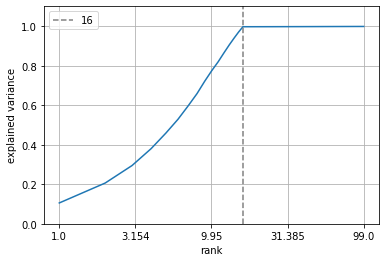

In [8]:

x = range(1, 100)
plt.plot(np.log10(x), score)

ax = plt.gca()
custom_plots.restore_natural_scale(
    ax, np.min(np.log10(x)), np.max(np.log10(x)), n_steps=5, x_axis=True, y_axis=False
)

plt.axvline(np.log10(16), color="grey", linestyle="--", label=16)
plt.xlabel("rank")
plt.ylabel("explained variance")
plt.legend()
plt.ylim(0,1.1)
plt.grid()

<AxesSubplot:>

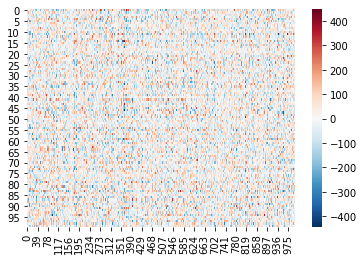

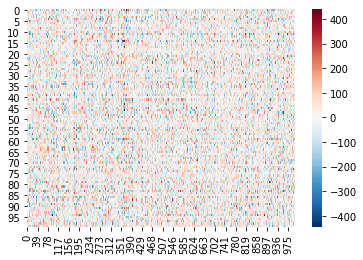

In [18]:
rrr = reduced_rank_regressor.ReducedRankRegressor(X,Y,16)
y_pred = rrr.predict(X)

plt.figure()
sns.heatmap(Y.T,cmap="RdBu_r")
plt.figure()

sns.heatmap(y_pred.T,cmap="RdBu_r")

In [21]:
rrr.W.shape, rrr.A.shape

((100, 16), (16, 500))